# Implementing on Neural Networks on Theano

In [5]:
import theano
import theano.tensor as T
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style("white")

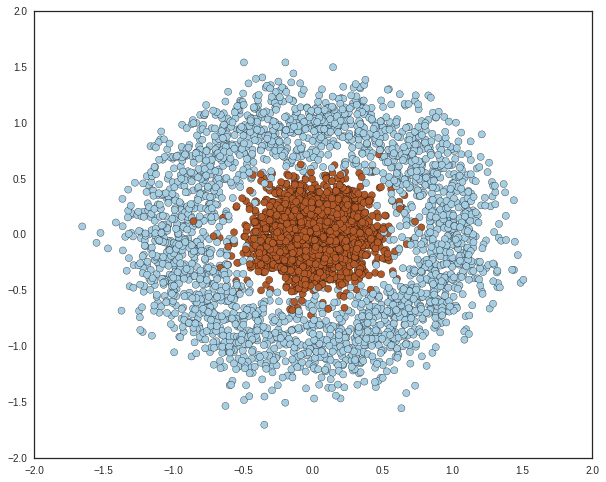

In [8]:
## Generate sample data.
train_X, train_y =  sklearn.datasets.make_circles(5000, noise=0.20, factor=0.1)

train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)

plt.scatter(train_X[:,0], train_X[:,1], s=50, c=train_y, cmap=plt.cm.Paired)

In [9]:
def plot_decision_boundary(pred_func):
    ## Copy data.
    X = train_X.copy()
    y = train_y.copy()
    # Set min and max values and give it some padding.
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.03
    # Generate a grid of points with distance h between them.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid.
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples.
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s = 50, c=y, cmap=plt.cm.Paired)

X & Y are stateless expressions; the eval method 'materializes' them.

In [10]:
X = T.matrix('X')
y = T.lvector('y')

(X * 2).eval({X :[[13,4,2],[2,2,4]]})

array([[ 26.,   8.,   4.],
       [  4.,   4.,   8.]])

Shared variables do have an internal state, and can be accessed from all functions. We will use them to store the model's parameters.

In [11]:
nn_examples = len(train_y)
nn_input_dim = 2
nn_hdim = 10
nn_output_dim = 2

## Lambda and epsilon.
l = 0.01
e = 0.01

def reset_params():
    W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
    b1 = theano.shared(np.zeros(nn_hdim), name = 'b1')
    W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
    b2 = theano.shared(np.zeros(nn_output_dim), name='b2')
    return W1, b1, W2, b2

W1, b1, W2, b2 = reset_params()

Next we define expresisons for the forward propagation, output probabilities and loss.

In [12]:
## Forward propagation.
z1 =X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2

## Probabilities.
y_hat = T.nnet.softmax(z2)

## Regularization term and loss.
l_loss = 1/float(nn_examples) *  l/2 * (T.sum(T.sqr(W1) + T.sum(T.sqr(W2))))
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + l_loss

## Prediction.
y_pred = T.argmax(y_hat, axis=1)

We can create interface functions that can be executed from python.

In [13]:
fwd_prop = theano.function([X], y_hat)
calc_loss = theano.function([X, y], loss)
predict = theano.function([X], y_pred)

print 'Sample forward propagation:'
fwd_prop([[1,2],[3,4]])

Sample forward propagation:


array([[ 0.80558042,  0.19441958],
       [ 0.86858597,  0.13141403]])

Now we will calculate the gradients for each of the parameters, but we won't do it manually. We will make use of Theano's gradient function and define the gradient descend step updates. Theano will also take care of the forward propagation, updating the parameters and minimizing the loss function (pretty convenient).

In [14]:
## Parameter's gradients.
dLdW1 = T.grad(loss, W1)
dLdb1 = T.grad(loss, b1)
dLdW2 = T.grad(loss, W2)
dLdb2 = T.grad(loss, b2)

## Function to perform gradient descend step.
gradient_step = theano.function([X,y],
                               updates = ((W1, W1 - e * dLdW1),
                                          (b1, b1 - e * dLdb1),
                                          (W2, W2 - e * dLdW2),
                                          (b2, b2 - e * dLdb2)))

Now we'll build the model and perform several iterations over it. Ideally we should see the loss value declining.

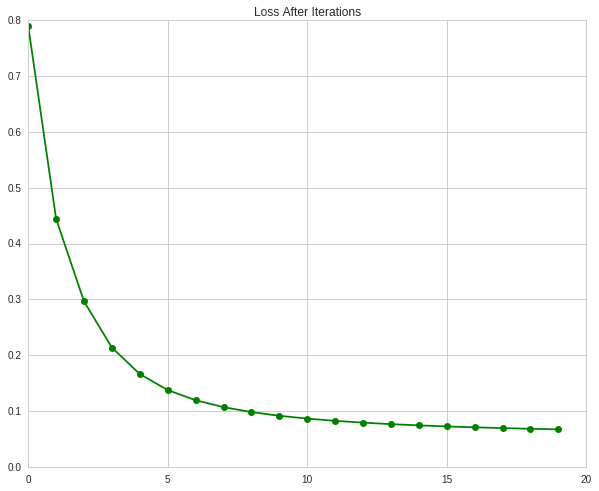

In [15]:
def build_model(passes=20000):
    W1, b1, W2, b2 = reset_params()
    model_loss = []
    for i in range(passes):
        gradient_step(train_X, train_y)
    
        if i % 1000 == 0:
            model_loss.append(calc_loss(train_X,train_y))
            #print 'Loss after %i iterations is: %f.' %(i, calc_loss(train_X,train_y))
    
    return model_loss
        
model_loss = build_model()
sns.set_style('whitegrid')
plt.plot(model_loss, 'go')
plt.plot(model_loss, 'g-')
plt.title('Loss After Iterations')

How long does a single gradient step takes to complete? How well does the model perform?

100 loops, best of 3: 2.74 ms per loop


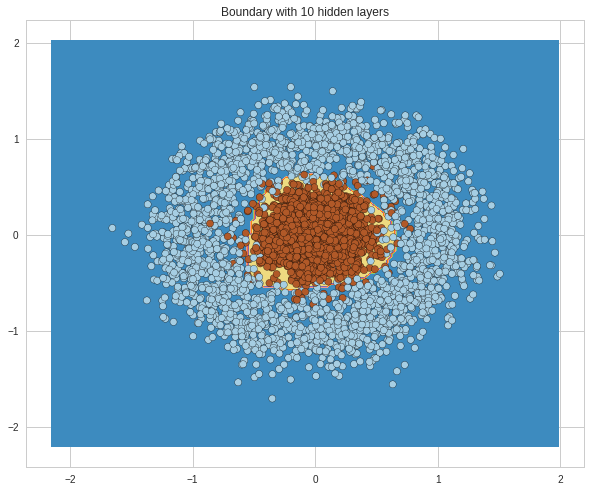

In [16]:
%timeit gradient_step(train_X, train_y)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
sns.set_style('white')
plt.title('Boundary with 10 hidden layers')

Theano is much more efficient than our implementation on Numpy. We can improve the running time further by adding GPU.